10장에서는 몇 개의 은닉층만으로 이루어진 얕은(shallow) 심층 신경망을 훈련했다.<br> 고해상도 이미지에서 수백 종류의 물체를 감지하는 것처럼 복잡한 문제를 다루려면,<br> 여러개의 층을 수십만 개의 가중치로 연결해 훨씬 더 깊은 심층 신경망을 훈련해야 할 것이다. => 매우 복잡

훈련 중에 마주칠 수 있는 문제
* 그레이디언트 소실 또는 그레이디언트 폭주 문제
* 훈련 데이터가 충분하지 않거나 레이블 만드는 작업에 드는 비용↑
* 훈련 속도↓↓↓↓
* 훈련 세트에 과대적합될 위험↑

11장에서는 위의 문제들을 살펴보고 해결 방법에 대해 알아볼 것이다.

#11.1 그레이디언트 소실과 폭주 문제

역전파 알고리즘을 이용해서 가중치들을 업데이트 하는데 이때 그레이디언트의 크기가 점점 커지거나 작아지는 경우가 있다.
* 그레이디언트 소실(vanishing gradient)
<br> : 그레이디언트 크기↓ => 그레이디언트=0 => 하위층 가중치 갱신 불가
* 그레이디언트 폭주(exploding gradient)
<br> 그레이디언트의 크기↑ => 큰 가중치로 갱신 => 알고리즘 발산

불안정한 그레이디언트는 층마다 학습 속도를 다르게 만들어 심층 신경망 훈련을 어렵게 만들기 때문에 꼭 해결할 필요가 있다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
# 로지스틱 활성화 함수 그리기(= sigmoid 함수)
def logit(z):
    return 1 / (1 + np.exp(-z))

def dv_logit(z):
    return logit(z) * (1-logit(z))

그림 저장: sigmoid_saturation_plot


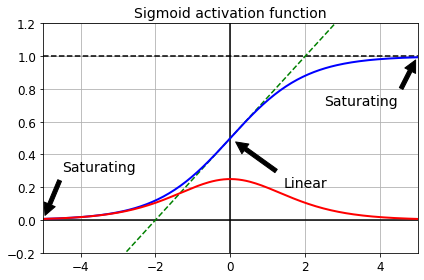

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
plt.plot(z, dv_logit(z), "r-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

위의 그래프를 보면, 입력값이 양수/음수로 커지면 0이나 1로 수렴하여 기울기가 0에 가까워지는 것을 볼 수 있다.<br> 그래서 역전파를 수행할 때 그레이디언트의 값이 계속해서 줄어들어 아랫층에는 전달될 그레이디언트가 없어지게 된다.

* sigmoid
<br>$\sigma(x) = \frac{1}{1 + e^{x}}$

* sigmoid 미분
<br>$\sigma'(x) = \sigma(1-\sigma)$

역전파를 할때 sigmoid 미분 값이 계속해서 곱해지게 되는데 sigmoid 미분 수식을 보면 1보다 작은 값이 계속해서 곱해진다. <br>즉, 그레이디언트 값이 0에 가까워짐을 알 수 있다.

##11.1.1 글로럿과 He 초기화

적절한 신호가 흐르기 위해서, 즉, 그레이디언트가 소실되거나 폭주하지 않기 위해서는, 
1. 각 층의 출력에 대한 분산 = 입력에 대한 분산
2. 역방향에서, 층을 통과하기 전 그레이디언트 분산 = 후의 그레이디언트 분산

이를 보장하기 위해서는 fan-in = fan-out 조건을 만족해야하는데
> fan-in : input layer의 뉴런 개수
<br> fan-out : output layer의 뉴런 개수

글로럿과 벤지오라는 사람이 입증된 대안을 제안하였다.

인공 신경망 학습에서, 같은 모델을 훈련시켜도 가중치의 초기값에 따라 모델의 훈련 결과가 달라지기도 한다.
<br> 가중치 초기화 방법인 글로럿 초기화, 세이비어 초기화, 크룬 초기화, He 초기화에 대해 알아보자.

* 글로럿 초기화(Glorot initialization) / 세이비어 초기화(Xavier initialization)
<br> 평균이 0이고 분산이 $\sigma^2 = \frac{2}{fan_{in} + fan_{out}}$ 인 **정규분포**
<br> 또는 $(-\frac{6}{fan_{in} + fan_{out}}, +\frac{6}{fan_{in} + fan_{out}})$ 사이의 **균등분포**

이 방법은 균등분포로 초기화 할 것이냐 아니면 정규분포로 초기화 할 것이냐 두가지 경우로 나뉜다.
* 균등분포는 미래 결과값이 경험적으로 알 수 없을 상황에서 사용
* 정규분포는 과거의 축적된 경험을 가지고 미래에 발생할 결과값을 어느정도 추정할 수 있을 때 사용

이전 층의 뉴런 개수와 다음 층의 뉴런 개수로 식을 세우며, **세워진 식 범위 내에서 랜덤하게 가중치를 초기화** 한다.

세이비어/글로럿 초기화 방법은 여러층의 그레이디언트 분산 사이에 균형을 맞춰서 특정 층이 너무 주목을 받거나 다른층이 뒤쳐지는 것을 막는다. => 훈련 속도를 높일 수 있다.<br>
S자 형태의 활성화 함수(sigmoid, tanh)와 함께 사용할 때는 좋은 성능을 보이나,
<br> ReLU와 사용할 때는 성능이 좋지 않다고 한다.(ReLU는 He 초기화 방법 사용)

* 르쿤 초기화(LeCun initialization)
<br> 평균이 0이고 분산이 $\sigma^2 = \frac{1}{fan_{in}}$인 정규분포
<br> 또는 $(-\frac{3}{fan_{in}}, + \frac{3}{fan_{in}})$ 사이의 균등분포
> $fan_{in} = fan_{out}$이면 르쿤 초기화는 글로럿 초기화와 동일

르쿤 초기화 방법은 SELU 함수에 사용해야한다고 한다.

In [ ]:
#케라스 initializer 목록
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [ ]:
# 케라스는 기본적으로 glorot_uniform 초기화 사용
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")       # activiation : 내가 쓸 활성화 함수
                                                                                # kernel_initializer : 초기화 방법_정규 또는 균등

In [ ]:
# fan_in 대신 fan_out 기반의 균등분포 He 초기화를 사용하고 싶으면
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',     # mode 기본값 = "fan_in"
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

##11.1.2 수렴하지 않는 활성화 함수

ReLU 함수는 특정 양숫값에 수렴하지 않는다는 장점이 있는 반면, <br>훈련 세트의 모든 샘플에 대해 가중치 합이 음수가 되면 뉴런이 죽는다는 단점이 있다.

<br>이 단점을 보안하기 위해 ReLU 함수의 변종을 사용한다.
* LeakyReLU 함수
<br> LeakyReLU$_{\alpha}(z) = $max$(\alpha z,z)$
> 하이퍼파라미터 $\alpha$
<br> : $z<0$ 일 때 함수의 기울기(default=0.01)
<br> : 음수일 때 기울기를 가지게 하여 함수의 기울기가 절대 0이 되지 않게 만들어준다.

※ LeakyReLU 함수의 성능 > ReLU 함수의 성능

* RReLU(randomized leaky ReLU) 함수
<br> 학습 시 균일 분포에서 $\alpha$값이 무작위로 샘플링 된
후 테스트에서는 평균을 사용

* PReLU(parametric leaky ReLU) 함수
<br> 다른 ReLU 변종 함수들과는 달리 $\alpha$는 스스로 학습하여 값을 조정하는 내부 파라미터이다.

In [ ]:
# LeakyReLU 함수 그리기
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


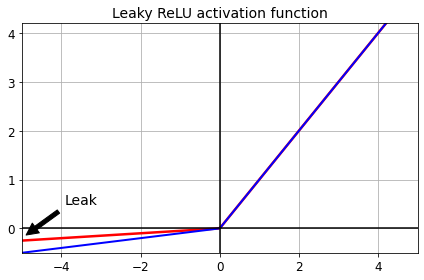

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "r-", linewidth=2.5)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [ ]:
# 케라스 활성화 함수 목록
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [ ]:
# ReLU 함수와 변종 함수 목록
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해보자.

In [ ]:
# MNIST 데이터셋 불러와서 train, test, valid set 나누기
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# LeakyReLU 알파값이 0.01
model1 = keras.models.Sequential([       # input_layer: 784, hidden_layer1: 300, hidden_layer2: 100, output_layer: 10 인 신경망
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),    # 300(units) : 출력값의 크기 # 정규분포 he 초기화 사용
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.Dense(10, activation="softmax")
])

# LeakyReLU 알파값이 0.2
model2 = keras.models.Sequential([       
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),    # 300(units) : 출력값의 크기 # 정규분포 he 초기화 사용
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history1 = model1.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
print("------------------------------------------------------------")
history2 = model2.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3462 - accuracy: 0.6204 - val_loss: 0.9251 - val_accuracy: 0.7176
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8195 - accuracy: 0.7354 - val_loss: 0.7300 - val_accuracy: 0.7624
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6961 - accuracy: 0.7695 - val_loss: 0.6557 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6325 - accuracy: 0.7907 - val_loss: 0.5997 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5912 - accuracy: 0.8053 - val_loss: 0.5651 - val_accuracy: 0.8184
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5614 - accuracy: 0.8138 - val_loss: 0.5402 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5387 - accuracy: 0.8206 - val_loss: 0.5194 - val_accuracy:

결론
<br> $\alpha=0.2$ 일 때와 $\alpha=0.01$ 일 때의 결과를 비교해봤을 때, $\alpha$값이 적당히 더 클 때 성능이 "조금" 더 좋은것으로 보인다.

PReLU를 사용해서 훈련시켜보자.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.ReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.ReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history1 = model1.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
history2 = model2.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

* ELU(exponential linear unit) 함수
<br> ELU$_{\alpha}(z) = 
\begin{cases} \alpha(e^{z}-1) \text{ if z < 0}\\
z \text{ if z} \geq{0}\\
\end{cases}$

<br> $z<0$일 때 음수값이 들어오기 때문에 활성화 함수의 평균 출력이 0에 더 가까워진다.
<br> $z<0$이여도 기울기가 0이 아니므로 죽은 뉴런을 만들지 않는다.
<br> 모든 구간에서 매끄러워 경사하강법의 속도를 높여준다.
<br> 다른 ReLU 변종 함수들보다 성능이 더 높다는 장점이 있지만 계산 속도가 느리다는 단점이 있다.


In [ ]:
# ELU함수 그리기
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


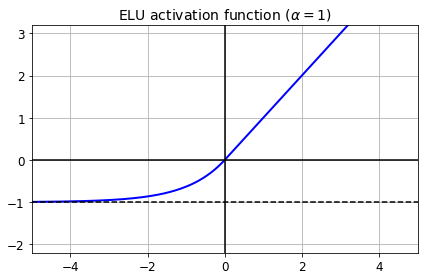

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

# keras.layers.Dense(10, activation="elu") 사용 가능

* SELU 함수(scaled ELU)<br>
SELU$_{\alpha}(z) = 
\begin{cases} \lambda(\alpha(e^{z}-1)) \text{ if z < 0}\\
\lambda z \text{ if z} \geq{0}\\
\end{cases}$
<br> 스케일이 조정된 ELU 활성화 함수의 변종이다.
<br> 훈련하는 동안 각 층의 출력이 평균 0, 표준편차 1을 유지하는 경향이 있어 그레이디언트 소실/폭주를 막는다.
<br> 특정 조건하에 자기 정규화(self-normalize)된다.
> 자기 정규화 조건
> 1. 입력 특성이 반드시 표준화(평균0, 표준편차1)되어야 함
> 2. 모든 은닉층의 가중치가 르쿤 정규분포 초기화로 초기화되어야 함
> 3. 네트워크가 일렬로 쌓은 층으로 구성되어야 함.

In [ ]:
from scipy.special import erfc      # erfc : 상보 오차 함수(1-erf)

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다(식은 논문 참조)
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


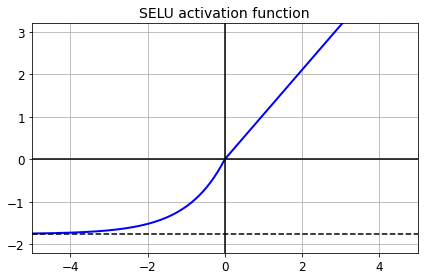

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [ ]:
# 각 층의 출력이 평균 0, 표준편차 1을 유지함을 보여줌
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [ ]:
# 케라스에서 바로 사용가능하다.
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [ ]:
# 나중에 사용함
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

##11.1.3 배치 정규화

ELU나 다른 ReLU 변종들과 함께 He 초기화를 사용하면 훈련 초기 단계에서의 그레이디언트 소실/폭주 문제를 감소시킬 수 있지만, <br>훈련하는 동안 다시 발생할지 안할지 모른다. 이를 방지하기 위해 배치 정규화를 사용한다.<br>
입력을 원점에 맞추고 정규화한 후, 각 층에서 스케일파라미터와 오프셋파라미터를 이용하여 스케일을 조정하고 이동시킨다.
<br> 즉, 각 층의 활성화 함수 출력값이 정규분포를 이루도록 데이터를 변환시킨다.

* 배치 정규화 알고리즘<br>
입력 데이터를 정규화하려면 평균과 표준편차 추정 필요 <br> => 현재 미니배치에서 입력의 평균과 표준편차를 평가
<br>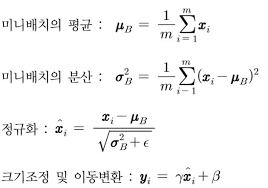

훈련하는 동안 배치 정규화는 입력을 정규화한 다음 스케일을 조정하고 이동시킨다.
<br>테스트 할 때는 각 훈련할 때 구했던 각 미니배치의 평균과 분산, 즉, 샘플 평균과 샘플 분산의 평균을 이용하여 정규화(3)를 하고 이미 훈련시켜서 가지고 있는 $\gamma,\beta$를 곱하고 더하여 크기조정 및 이동변환(4)을 한다.

심층 신경망에서 배치 정규화를 이용하면 성능을 크게 향상시킨다.
<br> 그레이디언트 소실 문제가 크게 감소하여 수렴성을 가진 활성화 함수(tanh, sigmoid)를 사용할 수 있다.

배치 정규화는 미니배치마다 평균과 표준편차를 계산하는데 이는 훈련데이터에 일종의 잡음을 넣는다고 볼 수 있다. 배치 정규화는 이런 잡음으로 훈련 세트에 과대적합되는 것을 방지하는 규제와 같은 역할을 한다.

<br> 입력 데이터를 정규화할 필요가 없다는 장점이 있는 반면에 층마다 계산이 추가되기 때문에 모델의 복잡도가 커지고 실행시간이 더 걸린다는 단점을 가지고 있기도 한다.
<br> 그래서 훈련이 끝나고 이전층과 배치 정규화 층을 합쳐서, 즉, 이전 층의 가중치와 편향을 업데이트된 가중치와 편향으로 바꾸어서 배치 정규화층을 제거한다.

In [ ]:
# 케라스로 배치 정규화 구현
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_15 (Dense)             (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_17 (Dense)             (None, 10)               

In [ ]:
# 배치 정규화 층의 파라미터 살펴보기
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]        
# gamma,beta는 역전파로 훈련되고, 나머지 두개는 non-trainable param이니까 안됨.

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
bn1.updates     # 케라스에서 배치 정규화 층을 만들때 생성된 연산으로 이동 평균(mu, sigma)을 업데이트함.

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


[]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8465 - accuracy: 0.7180 - val_loss: 0.5548 - val_accuracy: 0.8138
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5743 - accuracy: 0.8021 - val_loss: 0.4756 - val_accuracy: 0.8362
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5178 - accuracy: 0.8199 - val_loss: 0.4404 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4802 - accuracy: 0.8331 - val_loss: 0.4183 - val_accuracy: 0.8580
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4567 - accuracy: 0.8396 - val_loss: 0.4025 - val_accuracy: 0.8628
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4392 - accuracy: 0.8459 - val_loss: 0.3908 - val_accuracy: 0.8672
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4258 - accuracy: 0.8508 - val_loss: 0.3807 - val_accurac

배치 정규화 층을 활성화 함수 이후에 추가하는게 좋은지, 이전에 추가하는게 좋은지의 논란이 있기 때문에 <br>두가지 모두 실험해보고 더 좋은것을 선택하자.

In [ ]:
# 케라스로 배치 정규화 구현(배치 정규화 층이 은닉층의 활성화 함수 이후)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
'''model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),    # 배치 정규화 층에서 이동 파라미터 포함하니까 편향 빼기
    keras.layers.BatchNormalization(),      # 정규화를 하고 활성화 함수를 돌리느냐 아니면 활성화함수까지 돌리고 한번에 정규화하느냐의 차이
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),    
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])'''

'model = keras.models.Sequential([\n    keras.layers.Flatten(input_shape=[28, 28]),\n    keras.layers.BatchNormalization(),\n    keras.layers.Dense(300, use_bias=False),    # 배치 정규화 층에서 이동 파라미터 포함하니까 편향 빼기\n    keras.layers.BatchNormalization(),      # 정규화를 하고 활성화 함수를 돌리느냐 아니면 활성화함수까지 돌리고 한번에 정규화하느냐의 차이\n    keras.layers.Activation("relu"),\n    keras.layers.Dense(100, use_bias=False),    \n    keras.layers.BatchNormalization(),\n    keras.layers.Activation("relu"),\n    keras.layers.Dense(10, activation="softmax")\n])'

활성화 함수 전에 배치 정규화 층을 추가하려면 은닉층에서 활성화 함수를 지정하지 말고 배치 정규화층 뒤에 따로 층을 만들어서 추가해야한다.

batchnormalization 클래스 하이퍼파라미터
* momentum
<br> : 이동 평균 업데이트 할 때 사용
<br> : 일반적으로 1에 가까움(0.9,0.99 등)

* axis
<br> : 정규화할 축을 결정

##11.1.4 그레이디언트 클리핑

* 그레이디언트 클리핑(gradient clipping)
<br> 역전파될 때 일정 임곗값을 넘어서지 못하게 그레이디언트를 잘라내는 방법

In [ ]:
# 그레이디언트 클리핑 구현방법1(그레이디언트 벡터의 방향을 바꾸고 싶을 때)
optimizer = keras.optimizers.SGD(clipvalue=1.0)     

In [ ]:
# 그레이디언트 클리핑 구현방법2(그레이디언트 벡터의 방향을 바꾸지 않을 때)
optimizer = keras.optimizers.SGD(clipnorm=1.0)

매개변수를 1로 설정하면 그레이디언트 벡터의 모든 원소를 -1과 1 사이로 자른다는 뜻이다.
<br> 순환 신경망에서는 배치 정규화를 적용하기 어려워서 그레이디언트 클리핑 방법을 많이 사용한다고 한다.

# 11.2 사전훈련된 층 재사용하기

* 전이 학습(transfer learning)
<br> 이미 만든 신경망의 하위층을 재사용하는 것
<br> => 훈련속도↑, 필요한 훈련 데이터 수↓

##11.2.1 케라스를 사용한 전이 학습

패션 MNIST 훈련 세트를 두 개로 나누어 보자
* X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지, modelA에 대한 훈련세트
* X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트, modelB에 대한 훈련세트

검증 세트와 테스트 세트도 이렇게 나눈다.

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6)      # 샌들, 셔츠
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2       # 7, 8, 9 인덱스 5, 6, 7로 바꿔주기
    y_B = (y[y_5_or_6] == 6).astype(np.float32)      # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]     # 초반 200개만 선택
y_train_B = y_train_B[:200]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 패션 MNIST 데이터셋 분류 모델(샌들과 셔츠 제외) 만들기 = 모델 A
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))     # 은닉층에 selu 활성화 함수 사용
model_A.add(keras.layers.Dense(8, activation="softmax"))             # 출력층에는 softmax 사용

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",     
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5927 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2835 - accuracy: 0.9022 - val_loss: 0.2776 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2720 - val_accuracy:

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
# 샌들과 셔츠 이미지 구분하는 이진 분류기 = 모델 B(모델 A와 구조 거의 비슷)
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))        # 출력층에 sigmoid 사용(model A와 다른점)

In [ ]:
model_B.compile(loss="binary_crossentropy",     # 손실함수로 이진 크로스엔트로피 사용(modelA와 다른점)
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 36ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_18 (Dense)             (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_19 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_20 (Dense)             (None, 10)               

In [ ]:
# 모델 A를 기반으로 새로운 모델 model_B_on_A 만들기
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])     # 모델 A의 출력층을 제외한 모든 층 재사용
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))   # 출력층 새로 추가(sigmoid사용)

model_B_on_A 훈련할 때 model A도 영향을 받기 때문에 층을 재사용하기 전에 복제해야한다.


In [ ]:
model_A_clone = keras.models.clone_model(model_A)       # clone_model 메서드를 사용하여 구조 복제(가중치 복제 따로 해줘야함!!!!!)
model_A_clone.set_weights(model_A.get_weights())        # 가중치 복제

새로운 출력층이 랜덤하게 초기화되어 있기 때문에 초반 몇 번의 에포크 동안에는 큰 오차를 만들것이다.
<br> 이 오차가 재사용된 가중치(modelA에서 가져온 가중치)를 망칠 수 있기 때문에 <br>처음 몇번은 재사용된 층을 동결하고 새로운 층에 적절한 가중치를 학습할 시간을 줘야한다.

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False         # 재사용층 동결

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


※ 재사용층을 동결하거나 동결 해제하고 나서 반드시 모델을 컴파일해야한다!!!!!!!

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))      # 동결하고 몇번 훈련 돌리고

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True      # 재사용층 동결 해제

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-4),   # 동결 해제한 후에 학습률을 낮추는게 좋다 => 재사용된 가중치가 망가지는것 막아줌
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,     # 동결 해제하고 마저 돌리기
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 35ms/step - loss: 0.5728 - accuracy: 0.6550 - val_loss: 0.5777 - val_accuracy: 0.6389
Epoch 2/4
7/7 [==============================] - 0s 11ms/step - loss: 0.5370 - accuracy: 0.6850 - val_loss: 0.5409 - val_accuracy: 0.6836
Epoch 3/4
7/7 [==============================] - 0s 12ms/step - loss: 0.5008 - accuracy: 0.7300 - val_loss: 0.5094 - val_accuracy: 0.7130
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.4699 - accuracy: 0.7500 - val_loss: 0.4812 - val_accuracy: 0.7343
Epoch 1/16


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


7/7 [==============================] - 1s 38ms/step - loss: 0.4454 - accuracy: 0.7750 - val_loss: 0.4637 - val_accuracy: 0.7546
Epoch 2/16
7/7 [==============================] - 0s 16ms/step - loss: 0.4275 - accuracy: 0.8100 - val_loss: 0.4453 - val_accuracy: 0.7677
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.4089 - accuracy: 0.8200 - val_loss: 0.4288 - val_accuracy: 0.7799
Epoch 4/16
7/7 [==============================] - 0s 17ms/step - loss: 0.3925 - accuracy: 0.8250 - val_loss: 0.4139 - val_accuracy: 0.7951
Epoch 5/16
7/7 [==============================] - 0s 14ms/step - loss: 0.3777 - accuracy: 0.8400 - val_loss: 0.3994 - val_accuracy: 0.8103
Epoch 6/16
7/7 [==============================] - 0s 16ms/step - loss: 0.3631 - accuracy: 0.8450 - val_loss: 0.3857 - val_accuracy: 0.8286
Epoch 7/16
7/7 [==============================] - 0s 16ms/step - loss: 0.3495 - accuracy: 0.8600 - val_loss: 0.3734 - val_accuracy: 0.8408
Epoch 8/16
7/7 [======================

In [ ]:
model_B.evaluate(X_test_B, y_test_B)        # modelB의 [오차율, 정확도]

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)   # modelBonA의 [오차율, 정확도]

63/63 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 0.9100


[0.2876671254634857, 0.9100000262260437]

In [ ]:
(100 - 97.05) / (100 - 99.45)

5.363636363636396

오차율이 5배나 줄었다고 생각할 수 있지만, 타깃 클래스나 랜덤 초기값을 바꾸면 성능이 떨어질 것이다.
<br> 전이 학습은 '작은 완전 연결 네트워크'에서는 잘 동작하지 않고, 
<br> 조금 더 일반적인 특성을 감지하는 경향이 있는 '심층 합성곱 신경망'에서 잘 동작한다.

##11.2.2 비지도 사전훈련

풀어야 할 문제가 복잡 & 재사용할 수 있는 비슷한 모델X & 레이블된 훈련 데이터가 많지 않은 경우
<br> => 비지도 사전훈련(unsupervised pretraining) 사용
> 1. 레이블되지 않은 훈련 데이터를 가지고 오토인코더(autoencoder)나 생성적 적대 신경망(17장에서 배웁니다) 같은 비지도 학습 모델을 훈련
2. 위에서 말한 비지도 학습 모델의 하위층을 재사용하고 그 위에 맞는 출력층 추가
3. 레이블된 훈련 샘플(지도학습으로)을 가지고 최종 네트워크를 튜닝


##11.2.3 보조 작업에서 사전훈련

레이블된 훈련 데이터가 많지 않은 경우, 비지도 사전훈련 방법 말고 다른 방법이 하나 더 있다.
<br> 레이블된 훈련 데이터를 쉽게 얻거나 생성할 수 있는 '보조 작업'에서 첫번째 신경망을 학습하고 재사용하는 것이다.
<br> (여기서 첫번째 신경망의 하위층은 다음 신경망에 재사용될 수 있는 특성 추출기를 학습하게된다.)

# 11.3 고속 옵티마이저

심층 신경망의 훈련 속도 높이는 방법
1. 연결 가중치에 좋은 초기화 전략 사용하기
2. 좋은 활성화 함수 사용하기
3. 배치 정규화 사용하기
4. 사전 훈련된 네트워크의 일부 재사용하기
5. 더 빠른 옵티마이저 사용하기

##11.3.1 모멘텀 최적화

모멘텀 최적화는 **이전 그레이디언트가 얼마였는지** 중요하게 생각한다.

* 모멘텀 알고리즘
1. $m ← \beta m - \eta \nabla_{\theta} J(\theta)$
2. $\theta ← \theta + m$
> $\beta$ : 마찰저항(모멘텀이 너무 커지는 것을 막아줌)


* 모멘텀 알고리즘
1. $v_n = \alpha v_{n-1} - \eta \nabla_{\theta} J(\theta)$
2. $x_{n+1} = x_n + v_n$
> $v_n $ : 현재 속도
<br>$x_n$ : 현재 위치
<br> $\alpha$ : 과거 속도의 영향력/비중

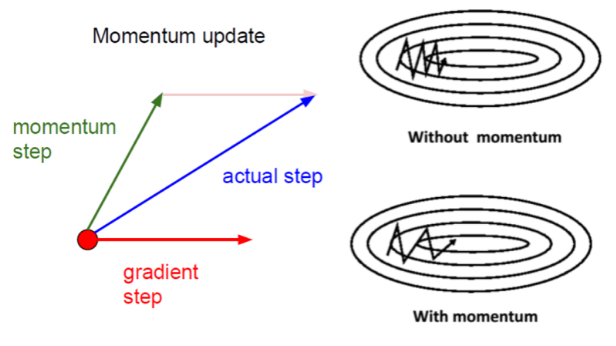

경사하강법은 가파른 경사는 빠르게 내려가지만 좁고 긴 골짜기 형태에서는 시간이 오래 걸린다. <br> 반면, 모멘텀 최적화는 골짜기를 따라 목표지점(최적점)에 도착할 때까지 점점 더 빠르게 내려간다.

In [ ]:
# 케라스에서 모멘텀 최적화 구현
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##11.3.2 네스테로프 가속 경사(NAG)

* 네스테로프 가속 경사 알고리즘
1. $m ← \beta m - \eta \nabla_{\theta} J(\theta+\beta m)$
2. $\theta ← \theta + m$

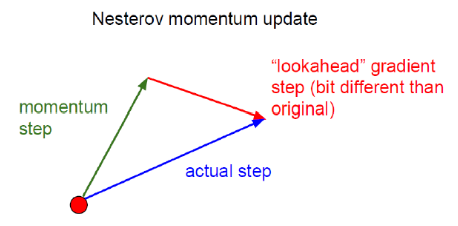

원래 위치에서의 그레이디언트를 사용하는 것보다 그 방향으로 조금 더 가서 측정한 그레이디언트를 사용하는 것이 조금 더 정확할 것이다.
<br> (이미 모멘텀 벡터가 올바른 방향을 가리키고 있기 때문에 조금 더 가는 것이 문제되지 않는다.)
<br> $\theta+\beta m$이 진동을 감소시키고 수렴을 빠르게 만들어주기 때문에 일반적으로 기본 모멘텀 최적화보다 NAG의 훈련 속도가 빠르다.


In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##11.3.3 AdaGrad

* AdaGrad 알고리즘
1. $s ← s + \nabla_ {\theta} J(\theta) \otimes\nabla_{\theta} J(\theta)$
2. $\theta ← \theta - \eta \nabla_ {\theta} J(\theta) \oslash \sqrt{s+\epsilon}$

AdaGrad는 **학습률을 감소**시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소한다.<br> 이처럼 모델이 최적점에 가까이 갈수록 낮아지는 학습률을 적응적 학습률이라 한다.


$s$가 과거의 기울기를 제곱해서 더해지는 값이니까 골짜기를 내려가면 갈수록 $s$값은 커지겠죠?
<br>그러면 학습률은 경사가 낮아질수록(최적점에 도달할수록) 작아질겁니다!

AdaGrad 알고리즘의 핵심은
**가중치마다 학습률이 다르게 적용된다는 것**

하지만 학습률이 너무 감소되어 전역 최적점에 도착하기 전에 알고리즘이 멈추는 경우가 많기 때문에 심층 신경망에서는 사용하지 말아야한다.(간단한 작업에는 ok)

In [ ]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##11.3.4 RMSProp

RMSProp 알고리즘은 모든 그레이디언트를 누적하는 것이 아니라,
<br> 먼 과거의 기울기는 점점 잊고 새로운 기울기 정보를 크게 반영함으로서 AdaGrad 알고리즘의 문제를 해결한다.

아래의 1번식에서 '지수 감소 평균' 방식을 적용한다.
> 지수 감소 평균이란?
<br> 데이터의 이동 평균을 구할 때, 오래된 데이터가 미치는 영향을
지수적으로 감쇠(exponential decay) 하도록 만들어 주는 방법.

* RMSProp 알고리즘
1. $s ← \beta s + (1-\beta)\nabla_ {\theta} J(\theta) \otimes\nabla_{\theta} J(\theta)$
2. $\theta ← \theta - \eta \nabla_ {\theta} J(\theta) \oslash \sqrt{s+\epsilon}$
> $\beta$ : 감쇠율(보통 0.9로 설정)

아주 간단한 문제를 제외하고는 RMSProp 알고리즘이 AdaGrad보다 늘, 훨씬 성능이 좋다.

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##11.3.5 Adam과 Nadam 최적화

* 적응적 모멘트 추정(adaptive moment estimation)
 <br> Adam = 모멘텀 최적화 + RMSProp

* Adam 알고리즘
1. $m ← \beta_1 m + (1-\beta_1)\nabla_ {\theta} J(\theta)$
2. $s ← \beta_2s + (1-\beta_2s)\nabla_ {\theta} J(\theta) \otimes\nabla_{\theta} J(\theta)$
3. $\hat m ← \frac{m}{1-\beta_1^t}$
4. $\hat s ← \frac{s}{1-\beta_2^t}$
2. $\theta ← \theta + \eta \hat m \oslash \sqrt{\hat s+\epsilon}$
> $t$ : 반복 횟수$(1,2,\dots)$

NOTE
*  모멘텀 감쇠 하이퍼파라미터 $\beta_1$은 보통 0.9로 초기화
* 스케일 감쇠 하이퍼파라미터 $\beta_2$는 보통 0.999로 초기화
* $\epsilon$은 보통 $10^{-8}$로 초기화(책에는 -7, 논문에는 -8)


위의 3번과 4번은 훈련 초기에 $m$과 $s$의 값을 증폭시키는데 도움을 준다.
<br> $m$과 $s$가 0부터 시작하기 때문에 $\beta_1 m$과 $\beta_2 s$가 반복 초기에 크게 기여를 하지 못한다.
<br> 이를 보상해주기 위해 반복 초기에 $m$과 $s$를 증폭시켜주지만 반복이 계속 진행되면 3,4번의 분모가 1에 가까워져 거의 증폭되지 않는다.

Adam은 AdaGrad, RMSProp처럼 적응적 학습률 알고리즘이라서 $\eta$를 튜닝할 필요가 적다. => 기본값 0.001사용

In [ ]:
# 케라스에서 adam 옵티마이저 사용하는법
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Adam의 두가지 변종
1. AdaMax
2. Nadam

* AdaMax 알고리즘
<br> Adam 알고리즘 5단계에서 $s$의 제곱근으로 파라미터 업데이트의 스케일을 낮춘다.
<br>즉, 감쇠된 그레이디언트의 $l_2$ 노름(제곱 합의 제곱근)으로 파라미터 업데이트의 스케일을 낮춘다.
<br> AdaMax에서는 $l_{2}$노름을 $l_{\infty}$노름으로 바꾸고 감쇠된 그레이디언트의 최대값으로 파라미터 업데이트의 스케일을 낮춘다.
1. $m ← \beta_1 m + (1-\beta_1)\nabla_ {\theta} J(\theta)$
2. $s ← $max$(\beta_2s, \nabla_ {\theta} J(\theta)$)
3. $\hat m ← \frac{m}{1-\beta_1^t}$
2. $\theta ← \theta + \eta \hat m \oslash \sqrt{s+\epsilon}$

In [ ]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


* Nadam
<br> Nadam = Adam + NAG

In [ ]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##11.3.6 학습률 스케줄링

큰 학습률로 시작해서 학습 속도가 느려지면 학습률을 낮추는 방법을 사용하면
<br> 고정 학습률을 사용하는 방법보다 더 빨리 좋은 솔루션을 찾을 수 있다.

* 학습 스케줄
<br> 훈련하는 동안 학습률을 감소시키는 방법(5가지)

1. 거듭제곱 기반 스케줄링
<br>$\eta(t)=\eta_0 / (1+t/s)^c$
> $\eta_0$ : 초기 학습률
<br>$c$ : 거듭제곱 수 => 보통 1
<br>$s$ : 스텝 횟수 => 하이퍼파라미터

     => 처음에는 빠르게 감소하다가 점점 더 느리게 감소됨


2. 지수 기반 스케줄링
<br>$\eta(t)=\eta_0$ x $ 0.1^{t/s}$
<br> => 학습률이 s번 스텝마다 10배씩 줄어듦


3. 구간별 고정 스케줄링
<br> => 일정 횟수의 에포크 동안 일정한 학습률을 사용하고, 또 다른 횟수의 에포크 동안 작은 학습률을 사용하는 방식


4. 성능 기반 스케줄링
<br> => 매 N 스텝마다 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$배만큼 학습률을 감소시킴


5. 1사이클 스케줄링
<br> => 훈련 절반동안 초기 학습률을 선형적으로 $\eta_1$까지 증가시킴
<br> => 나머지 절반 동안 선형적으로 $\eta_0$로 줄임
<br> => 마지막 몇번은 학습률을 소수점 몇 째 자리까지 줄임
<br> 즉, 최대 학습률 $\eta_1$은 최적의 학습률을 찾을 때와 같은 방식으로 선택하고 초기 학습률 $\eta_0$는 대략 10배 정도 낮은 값을 선택


#11.4 규제를 사용해 과대적합 피하기

규제 방법
* 조기 종료
* 배치 정규화
* $l_1, l_2$ 규제
* 드롭아웃(dropout)
* 맥스-노름(max-norm)

##11.4.1 $l_1$ 과 $l_2$ 규제

$l_2$ 함수는 훈련하는 동안 규제 손실을 계산하기 위해 각 스텝에서 호출되는 규제 객체를 반환한다. 
<br>이 손실은 최종 손실에 합산된다.

In [ ]:
#l2 규제 적용하는 방법
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
# 실제로 사용해보자
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 7ms/step - loss: 1.6185 - accuracy: 0.8115 - val_loss: 0.7141 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7180 - accuracy: 0.8273 - val_loss: 0.6775 - val_accuracy: 0.8364


In [ ]:
# 코드 읽기 쉽고 버그 생기지 않게 functools.partial() 함수 사용
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 1.6586 - accuracy: 0.8129 - val_loss: 0.7181 - val_accuracy: 0.8330
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7192 - accuracy: 0.8275 - val_loss: 0.6829 - val_accuracy: 0.8384


##11.4.2 드롭아웃

드롭아웃은 심층 신경망에서 가장 인기 있는 규제 기법 중 하나이다.

* 드롭아웃
<br> 매 훈련 스텝에서 각 뉴런(입력o, 출력x)은 임시적으로 드롭아웃될 확률 p를 가진다.
<br> 이번 훈련 스텝에서는 무시되지만 다음 스텝에는 활성화 될 수 있다.
<br> 훈련이 끝난 후에는 뉴런에 더이상 드롭아웃을 적용하지 않는다.

=> 드롭아웃으로 훈련된 뉴런은 다른 뉴런들과 유연한 관계를 유지하기 때문에, 더 안정적인 네트워크가 되어 일반화 성능이 좋아짐.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),             # 각 층에 들어가기 전에 드롭아웃 적용
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5720 - accuracy: 0.8037 - val_loss: 0.3673 - val_accuracy: 0.8658
Epoch 2/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4235 - accuracy: 0.8469 - val_loss: 0.3512 - val_accuracy: 0.8690


훈련할 때 임의의 뉴런을 골라 삭제하지만 테스트할 때는 모든 뉴런을 사용한다.


* 모델이 과대적합 => 드롭아웃 비율↑
* 모델이 과소적합 => 드롭아웃 비율↓
* 층이 클 때 => 드롭아웃 비율↑
* 층이 작을 때 => 드롭아웃 비율↓

만약 SELU 활성화 함수를 기반으로 자기 정규화하는 네트워크를 규제하고 싶을 때 => 알파 드롭아웃 사용

In [ ]:
# 알파 드롭아웃 규제(SELU와 함께)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6656 - accuracy: 0.7591 - val_loss: 0.5716 - val_accuracy: 0.8498
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5548 - accuracy: 0.7978 - val_loss: 0.5485 - val_accuracy: 0.8482
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5223 - accuracy: 0.8057 - val_loss: 0.4801 - val_accuracy: 0.8612
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5073 - accuracy: 0.8127 - val_loss: 0.4883 - val_accuracy: 0.8558
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4905 - accuracy: 0.8193 - val_loss: 0.4383 - val_accuracy: 0.8634
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4834 - accuracy: 0.8204 - val_loss: 0.4456 - val_accuracy: 0.8626
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4718 - accuracy: 0.8227 - val_loss: 0.4834 - val_accuracy

##11.4.3 몬테 카를로 드롭아웃

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])     # 테스트 세트에서 100번의 예측을 만들어서 스택에 쌓음
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
# 패션 MNIST 테스트 세트에 있는 첫번째 샘플의 모델 예측(드롭아웃 적용X)
np.round(model.predict(X_test_scaled[:1]), 2)   # 클래스 9에 속한다고 예측

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# 드롭아웃 적용하고 만든 예측
np.round(y_probas[:, :1], 2)    # 클래스9를 선호하지만 클래스 5,7로도 생각함

In [ ]:
# 첫번째 차원으로 평균내기
np.round(y_proba[:1], 2)    # 아까보다 덜 확실하게 클래스9로 예측  

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.22, 0.  , 0.66]],
      dtype=float32)

In [ ]:
# 위의 확률 추정의 표준분포
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)      # 예측이 불확실함

array([[0.  , 0.  , 0.  , 0.01, 0.  , 0.21, 0.  , 0.22, 0.  , 0.29]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
# 모델의 정확도
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8641

배치 정규화 층처럼 모델이 훈련하는 동안 다르게 작동하는 층이 있다면 훈련 모드를 강제로 설정해서는 안된다.
<br> 이러한 층이 있을 경우에는 드롭아웃 층을 아래와 같은 MCDropout 클래스로 바꿔주면 된다.

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):                             
        return super().call(inputs, training=True)      # 드롭아웃 층을 상속하고 call() 메서드로 훈련모드 강제 설정

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

##11.4.4 맥스 노름

각각의 뉴런에 대해, 입력의 연결 가중치 $w$가 $\parallel w \parallel_2$ $ \leq r$되도록 제한<br>($r$ : 맥스-노름 하이퍼파라미터)

이 규제는 전체 손실 함수에 규제 손실 항을 추가하지 않지만,<br> 매 훈련 스텝이 끝나고 $\parallel w \parallel_2$ 을 계산하고 필요할 경우 스케일을 조정한다. ($w ← w \frac{r}{\parallel w \parallel_2}$)

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,       # 매 훈련 반복이 끝난 후, 층의 가중치와 max_norm()이 반환한 객체를 호출하고
                                                                    # 스케일이 조정된 가중치를 반환 받음.
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4741 - accuracy: 0.8329 - val_loss: 0.3758 - val_accuracy: 0.8650
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3549 - accuracy: 0.8720 - val_loss: 0.3717 - val_accuracy: 0.8718
